In [1]:
import pandas as pd
from typing import List, Set
import matplotlib.pyplot as plt
import numpy as np
from sqlite3 import connect

In [2]:
df = pd.read_csv('vgchartz-2024.csv')

In [3]:
class VideoGameSalesAnalyzer:
    def __init__(self, data_file):
        self.df = pd.read_csv(data_file)
    
    def clean_data(self: pd.DataFrame) -> pd.DataFrame:
        """
        Cleans the instance's DataFrame by performing the following steps:
        - Creates a copy of the original DataFrame to preserve immutability.
        - Converts the 'release_date' column to datetime format.
        - Drops the 'img' and 'last_update' columns from the DataFrame.
        - Removes rows where the 'release_date' column contains NaN values.
        - Fills NaN values in specific numeric columns with 0.

        Modifies:
        ---------
        self.df : pd.DataFrame
            The DataFrame stored in the instance, updated with all cleaning steps applied.

        Returns:
        --------
        None
            This method modifies `self.df` in place and does not return a value.
        """
        self.df = self.df.copy()
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        self.df.drop(['img', 'last_update'], axis=1, inplace=True)
        self.df = self.df.dropna(subset=['release_date'])
        columns_to_fill_zero = ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
        self.df.loc[:, columns_to_fill_zero] = self.df.loc[:, columns_to_fill_zero].fillna(0)
        return self.df
        
    
    def assign_console_mfg(self: pd.DataFrame) -> pd.DataFrame:
        """
        Assigns a manufacturer to each console in the DataFrame based on predefined categories.

        Categories define mappings of console manufacturers to associated console identifiers. 
        - Checks if all console identifiers are covered using `self.check_missing_items`.
        - Adds a new column `console_mfg` to the DataFrame, assigning manufacturers based on the `console` column.
        If a console is not found in any category, it is assigned a value of 'unknown'.

        Returns:
        --------
        pd.DataFrame
            The updated DataFrame with the `console_mfg` column added.
        """
        categories = {
            'nintendo': ['3ds', 'dsiw', 'dsi', 'ds', 'wii', 'wiiu', 'ns', 'gb', 'gba', 'nes', 'snes', 'gbc', 'n64', 'vb', 'gc', 'vc','ww'],
            'pc': ['linux', 'osx', 'pc', 'arc', 'all', 'fmt', 'c128', 'aco'],
            'xbox': ['x360', 'xone', 'series', 'xbl', 'xb', 'xs'],
            'sony': ['ps', 'ps2', 'ps3', 'ps4', 'ps5', 'psp', 'psv', 'psn', 'cdi'],
            'mobile': ['ios', 'and', 'winp', 'ngage', 'mob'],
            'sega': ['gg', 'msd', 'ms', 'gen', 'scd', 'sat', 's32x', 'dc'],
            'atari': ['2600', '7800', '5200', 'aj', 'int'],
            'commodore': ['amig', 'c64', 'cd32'],
            'other': ['ouya', 'or', 'acpc', 'ast', 'apii', 'pce', 'zxs', 'lynx', 'ng', 'zxs', '3do', 'pcfx', 'ws', 'brw', 'cv', 'giz', 'msx', 'tg16', 'bbcm']
        }

        all_items = [item for sublist in categories.values() for item in sublist]

        missing_items = self.check_missing_items(all_items)

        if missing_items:
            print(f"Missing items: {missing_items}")
        else:
            print("All items are covered.")

        conditions = [self.df['console'].isin(items) for items in categories.values()]
        values = list(categories.keys())

        self.df['console_mfg'] = np.select(conditions, values, default='unknown')
        return self.df
    

    def check_missing_items(self, all_items: List[str]) -> Set[str]:
        """
        Checks for items in the provided list that are not present in the DataFrame's `console` column.

        This method compares the `all_items` list against the unique values in the `console` column of 
        the DataFrame, after converting both to lowercase and stripping whitespace.

        Parameters:
        -----------
        all_items : List[str]
            A list of console identifiers to check for in the `console` column of the DataFrame.

        Returns:
        --------
        Set[str]
            A set of items from `all_items` that are not found in the `console` column of the DataFrame.
        """
        all_items_lower = [item.lower().strip() for item in all_items]
        unique_values_lower = set(self.df['console'].str.lower().str.strip().unique())
        return set(all_items_lower) - unique_values_lower


    def filter_and_group_by_year(self, target_year: int) -> pd.DataFrame:
        """
        Filters the DataFrame for a specific target year and groups the data by `release_date` and `console`,
        calculating the total sales for each group.

        This method processes the following steps:
        1. Converts the `release_date` column to datetime.
        2. Filters the rows to include only those where the release year matches the `target_year`.
        3. Groups the filtered data by `release_date` and `console`, summing the `total_sales` column.
        4. Ensures the `release_date` column contains only the year after grouping.
        5. Groups the data again by `release_date` and `console`, summing `total_sales`.

        Parameters:
        -----------
        target_year : int
            The target year for filtering the DataFrame.

        Returns:
        --------
        pd.DataFrame
            A DataFrame with the grouped and aggregated sales data, containing the columns:
            - `release_date`: The release year.
            - `console`: The console identifier.
            - `total_sales`: The summed sales for each group.
        """
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        df_filtered = self.df[self.df['release_date'].dt.year == target_year]
        result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
        result['release_date'] = result['release_date'].dt.year  
        result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
        return self.df
    

    def single_graph(self, date_range: tuple[int, int], console: str) -> None:
        """
        Creates a bar chart showing the total sales of a specific console over a specified date range, 
        including a trend curve.

        This method processes the following steps:
        1. Converts the `release_date` column to datetime format.
        2. Filters the DataFrame based on the provided `date_range` and `console`.
        3. Groups the filtered data by release year and calculates the total sales for each year.
        4. Plots a bar chart of total sales by year and overlays a quadratic trend curve.

        Parameters:
        -----------
        date_range : tuple[int, int]
            A tuple containing the start year and end year for filtering the data (inclusive).
        console : str
            The console identifier for which the sales data is to be plotted.

        Returns:
        --------
        None
            This method does not return any value. It displays the plot directly.
        """
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                              (self.df['release_date'].dt.year <= date_range[1]) & 
                              (self.df['console'] == console)]

        sales_by_year = filtered_df.groupby(filtered_df['release_date'].dt.year)['total_sales'].sum().reset_index()

        plt.figure(figsize=(10, 6))
        plt.bar(sales_by_year['release_date'], sales_by_year['total_sales'], label='Total Sales')
        
        # Trend curve
        x = sales_by_year['release_date']
        y = sales_by_year['total_sales']
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        trend_line = np.maximum(p(x), 0)  
        plt.plot(x, trend_line, 'r--', label='Trend Curve')
        
        plt.xlabel('Year')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales of {console} from {date_range[0]} to {date_range[1]}')
        plt.legend()
        
        plt.show()
        return None


    def stacked_graph(self, date_range: tuple[int, int], *consoles: str) -> None:
        """
        Creates a stacked bar chart comparing the total sales of multiple consoles over a specified date range,
        with trend curves for each console.

        This method processes the following steps:
        1. Converts the `release_date` column to datetime format.
        2. Filters the DataFrame based on the provided `date_range` and the specified consoles.
        3. Groups the filtered data by release year and console, summing the `total_sales` for each group.
        4. For each console:
            - Plots a bar chart of total sales by year.
            - Adds a trend curve using a quadratic fit.
        5. Displays the total sales comparison and trend curves for all the selected consoles.

        Parameters:
        -----------
        date_range : tuple[int, int]
            A tuple containing the start year and end year for filtering the data (inclusive).
        *consoles : str
            A variable number of console identifiers to include in the plot. Only data for these consoles will be displayed.

        Returns:
        --------
        None
            This method does not return any value. It displays the plot directly.
        """
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                              (self.df['release_date'].dt.year <= date_range[1]) & 
                              (self.df['console'].isin(consoles))]
        sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

        plt.figure(figsize=(12, 8))

        for console in consoles:
            console_data = sales_by_year[sales_by_year['console'] == console]
            x = console_data['release_date'].dt.year  
            y = console_data['total_sales']
        
            # Trend curve
            z = np.polyfit(x, y, 2)
            p = np.poly1d(z)
            # Clip values below 0
            trend_line = np.maximum(p(x), 0) 
        
            # Bar plot
            plt.bar(x, y, label=f'Total Sales - {console}')
        
            # Trend curve plot
            plt.plot(x, trend_line, '--', label=f'Trend Curve - {console}')

        plt.xlabel('Year')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')

        # Display legend
        plt.legend()
        plt.show()
        return None
    
    
    def graph_genre_quarterly(self, date_range: tuple[int, int], *genres: str) -> None:
        """
        Generates a side-by-side bar chart comparing the total sales of different genres for each quarter 
        over a specified date range.

        This method processes the following steps:
        1. Converts the `release_date` column to datetime format.
        2. Filters the DataFrame based on the provided `date_range` and the specified genres.
        3. Adds a `quarter` column to the DataFrame to represent the quarter of each release.
        4. Groups the filtered data by quarter and genre, summing the `total_sales` for each group.
        5. Plots a bar chart with side-by-side bars for each genre for each quarter in the date range.

        Parameters:
        -----------
        date_range : tuple[int, int]
            A tuple containing the start year and end year for filtering the data (inclusive).
        *genres : str
            A variable number of genre identifiers to include in the plot. Only data for these genres will be displayed.

        Returns:
        --------
        None
            This method does not return any value. It displays the plot directly.
        """
      
        self.df['release_date'] = pd.to_datetime(self.df['release_date'])
        
        filtered_df = self.df[(self.df['release_date'].dt.year >= date_range[0]) & 
                        (self.df['release_date'].dt.year <= date_range[1]) & 
                        (self.df['genre'].isin(genres))].copy()
        
        filtered_df['quarter'] = filtered_df['release_date'].dt.to_period("Q")
        
        sales_by_quarter = filtered_df.groupby(['quarter', 'genre'])['total_sales'].sum().reset_index()

        plt.figure(figsize=(15, 8))
        
        quarters = sales_by_quarter['quarter'].unique().astype(str)
        width = 0.2  # Adjusted width to make bars side-by-side
        
        for i, genre in enumerate(genres):
            genre_data = sales_by_quarter[sales_by_quarter['genre'] == genre]
            x = np.arange(len(quarters)) + i * width  # Adjusted x positions for side-by-side bars
            y = genre_data.groupby('quarter')['total_sales'].sum().reindex(quarters).fillna(0)
            
            cmap = plt.get_cmap('tab10')
            bar_color = cmap(i)
            
            plt.bar(x, y, width=width, color=bar_color, label=genre)
        
        plt.xlabel('Quarter')
        plt.ylabel('Total Sales')
        plt.title(f'Total Sales Comparison of Genres from {date_range[0]} to {date_range[1]} (Quarterly)')
        
        plt.legend(loc='upper left')
        plt.xticks(ticks=np.arange(len(quarters)) + width * (len(genres) - 1) / 2, labels=quarters, rotation=90)
        
        plt.show()
        return None
    

In [4]:
# Example usage
analyzer = VideoGameSalesAnalyzer('vgchartz-2024.csv')
analyzer.clean_data()
analyzer.assign_console_mfg()

sales_2022 = analyzer.filter_and_group_by_year(2021)
sales_2022.head()

All items are covered.


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,console_mfg
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,unknown
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,unknown
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,unknown
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,0.0,15.86,9.06,0.06,5.33,1.42,2013-09-17,unknown
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,unknown


In [5]:
for year in range(1971, 2024):
    df_name = f"sales_{year}"
    globals()[df_name] = analyzer.filter_and_group_by_year(year)

In [6]:
sales_2022.head()

,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,console_mfg
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,unknown
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,unknown
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,unknown
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,0.0,15.86,9.06,0.06,5.33,1.42,2013-09-17,unknown
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,unknown


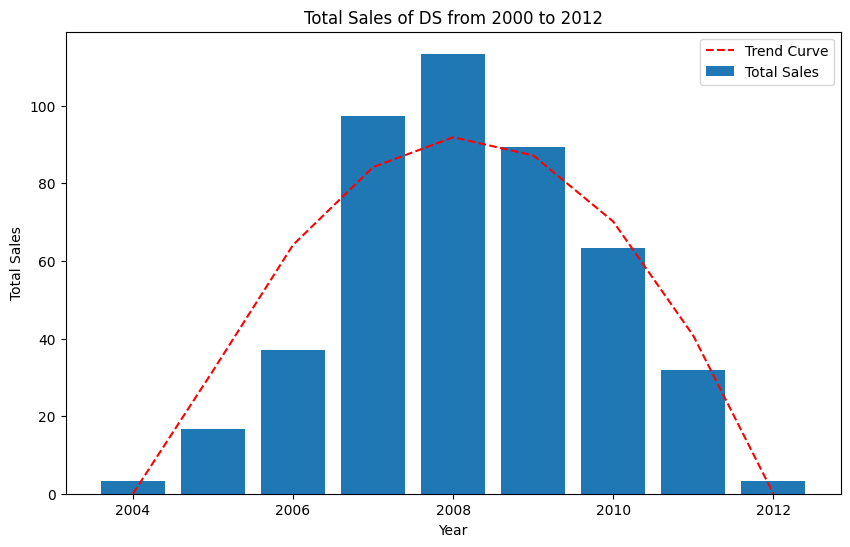

In [12]:
analyzer.single_graph((2000, 2012), 'DS')

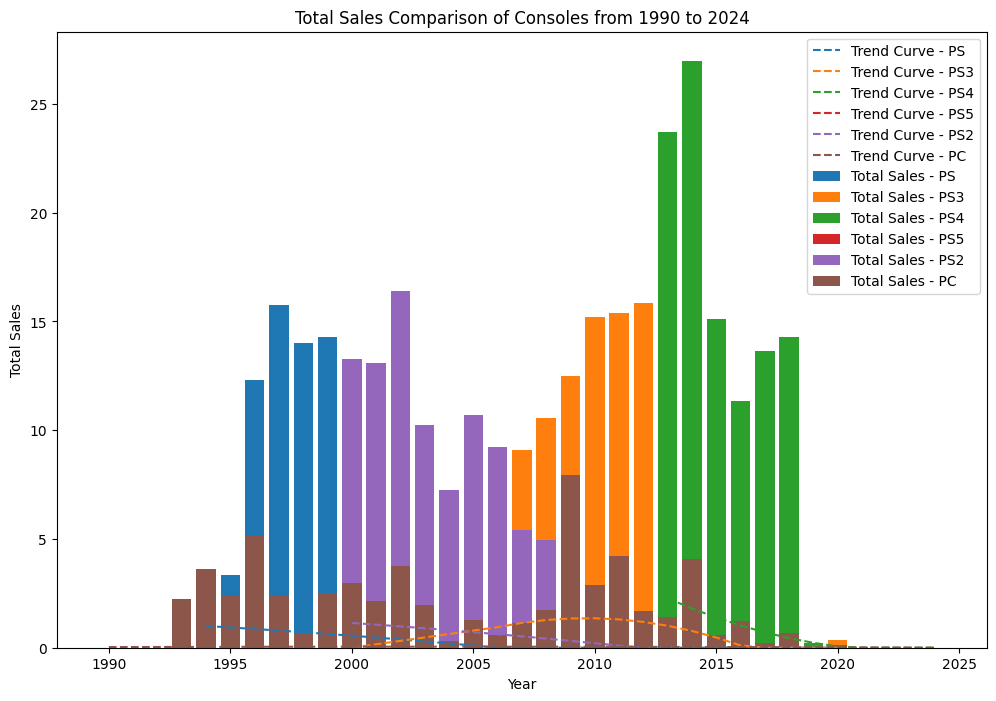

In [8]:
analyzer.stacked_graph((1990, 2024), 'PS', 'PS3', 'PS4', "PS5", 'PS2', 'PC')

In [9]:
# Example usage
analyzer = VideoGameSalesAnalyzer('vgchartz-2024.csv')
analyzer.clean_data()
analyzer.assign_console_mfg()

sales_2022 = analyzer.filter_and_group_by_year(2021)
sales_2022.head()


All items are covered.


,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,console_mfg
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,unknown
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,unknown
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,unknown
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,0.0,15.86,9.06,0.06,5.33,1.42,2013-09-17,unknown
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,unknown


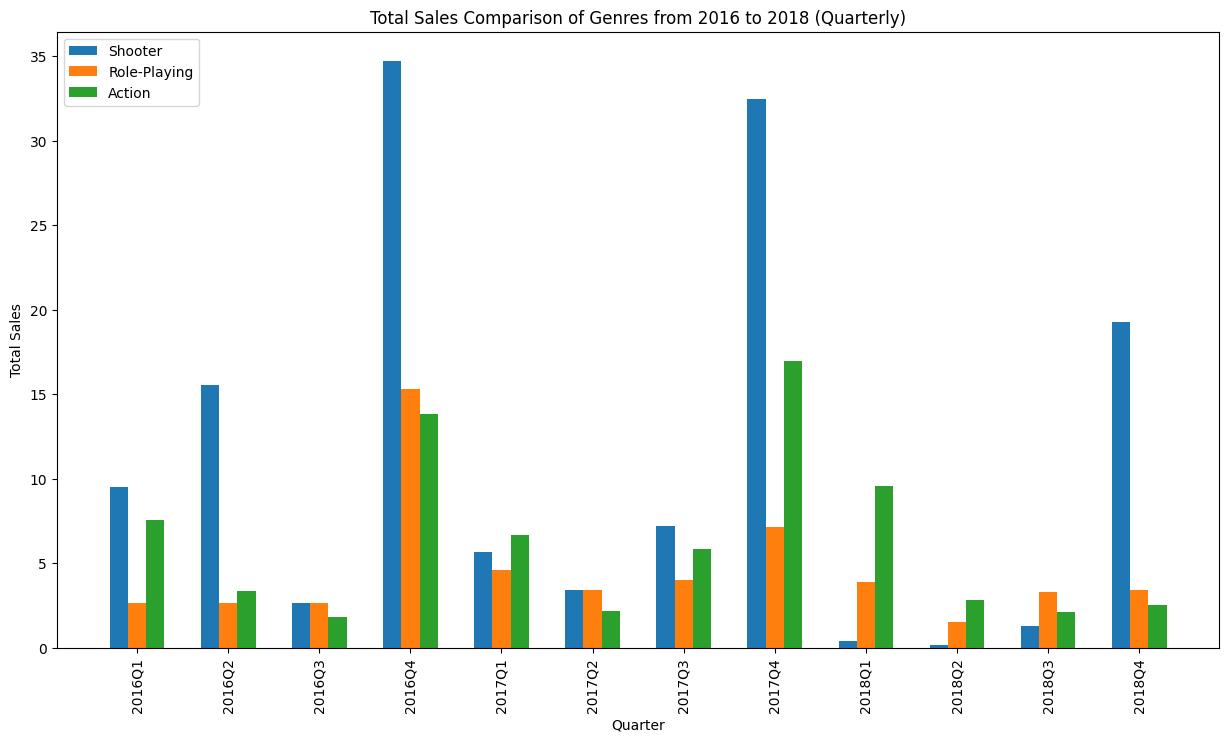

In [10]:
analyzer.graph_genre_quarterly((2016,2018), 'Shooter', 'Role-Playing', 'Action')

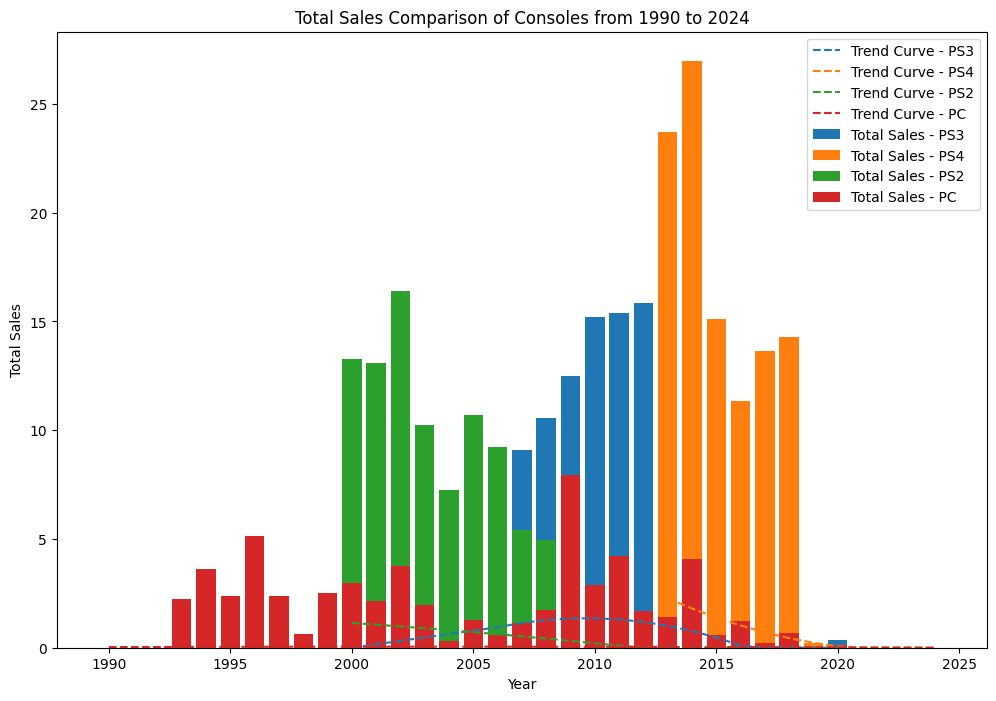

In [11]:
analyzer.stacked_graph((1990, 2024), 'PS3', 'PS4', 'PS2', 'PC')